## 1. Load the pre-precessed training/testing data

Dataset download from: https://msnews.github.io/

In [1]:
# load the training data

import csv
with open ("data/BERT_VEC/train.csv",'r',encoding="utf8") as f:
    read_csv = csv.reader(f, delimiter=',')
    next(read_csv)
    news_train = [new for new in read_csv]
categories = list(set([new[0] for new in news_train]))

# load the testing data

with open ("data/BERT_VEC/test.csv",'r',encoding="utf8") as f:
    read_csv = csv.reader(f, delimiter=',')
    next(read_csv)
    news_test = [new for new in read_csv]
    
import numpy as np

sen_vec_train = np.load("data/BERT_VEC/train_v2.npy")

sen_vec_test = np.load("data/BERT_VEC/test.npy")

print("Training: ", len(news_train), "Vector: ",sen_vec_train.shape)
print("Testing: ", len(news_test), "Vector: ",sen_vec_test.shape)

# convert the label from string to int for training data

train_label = np.zeros(len(news_train))

temp = [new[0] for new in news_train]

for i in range(len(categories)):
    print(i,":",categories[i])
    for j in range(len(temp)):
        if temp[j] == categories[i]:            
            train_label[j] = i   
            
# convert the label from string to int for testing data
test_label = np.zeros(len(news_test))

temp = [new[0] for new in news_test]

for i in range(len(categories)):
    #print(i,":",categories[i])
    for j in range(len(temp)):
        if temp[j] == categories[i]:            
            test_label[j] = i 

Training:  101419 Vector:  (101419, 768)
Testing:  120889 Vector:  (120889, 768)
0 : health
1 : finance
2 : video
3 : entertainment
4 : lifestyle
5 : weather
6 : foodanddrink
7 : tv
8 : autos
9 : sports
10 : news
11 : movies
12 : music
13 : travel


In [2]:
# Only use 11200(14*800) data points for training/testing data

news_test_vec = []
news_test_label = []
for i in range (14):
    for vec in sen_vec_test[test_label==i][:800]:        
        news_test_vec.append(vec)
        news_test_label.append(i)
        
news_train_vec = []
news_train_label = []
for i in range (14):
    for vec in sen_vec_train[train_label==i][:800]:        
        news_train_vec.append(vec)
        news_train_label.append(i)

news_train_vec = np.array(news_train_vec)
news_train_label = np.array(news_train_label)
news_test_vec = np.array(news_test_vec)
news_test_label = np.array(news_test_label)
print(news_train_vec.shape,news_test_vec.shape)

(11200, 768) (11200, 768)


In [3]:
# Alternatively, perform cross validation(training:teseting = 7:1)

from sklearn.model_selection import StratifiedKFold

X = np.vstack((news_train_vec,news_test_vec))
y = np.concatenate((news_train_label,news_test_label))
print(X.shape,y.shape)
skf = StratifiedKFold(n_splits=8,random_state=1, shuffle=True)
gen = skf.split(X,y)
indices = []
for index in gen:
    indices.append(index)

(22400, 768) (22400,)


## 2. Maximum Likelihood Estimation of Gaussian Parameters

#### Maximum Likelihood Estimation

We are given: 
    
- some data $X$
- some hypothesized generating function of the data $f(X,θ)$
- a set of parameters from that function $θ$
- some evaluation of the goodness of our parameters (an objective function)

In MLE, the objective function (evaluation) we chose is the likelihood of the data given our model. When adjusting $θ$, we need to find the $θ$ which maximize the the likelihood. The general formula of MLE is:

$
\theta_{MLE} = \mathop{argmax}\limits_{\theta} p(X|\theta) 
$

#### Likelihood for a Gaussian

The likelihood function of Gaussain $\mathcal{L}$ is its p.d.f.

$
\mathcal{L} = p(X|\theta)
            = \mathcal{N}(X|\theta)
            = \mathcal{N}(X|\mu,\Sigma)
$

where $\mu,\Sigma$ are the mean and covariance matrix. we need to find good estimates of both parameters:

$
\mathop{argmax}\limits_{\mu} = \mathop{argmax}\limits_{\mu} p(X|\mu,\Sigma) 
$

$
\mathop{argmax}\limits_{\Sigma} = \mathop{argmax}\limits_{\Sigma} p(X|\mu,\Sigma) 
$

By taking the partial derivatives of $\mathcal{N}(X|\mu,\Sigma)$ with respect to $\mu,\Sigma$ respetively, let them equals $0$ and solve for $\mu,\Sigma$. Then we are able to show that:

$
\mu_{MLE} = \frac{1}{N}\sum\limits_{n=1}^N {x_n}
$

$
\Sigma_{MLE} = \frac{1}{N}\sum\limits_{n=1}^N {(x_n-\mu)^2}
$

which are the emperical mean and covariance.

#### Classification

Suppose we have a number of data points $x_{11},...,x_{kk} \in \mathop{R}^n $ corresponding to some predefined $k$ labels $Y_1,...Y_k$, we train a classifier to classify a unseen new data point $x$ as follow:

$
\hat{Y} = \mathop{argmax}\limits_{Y_i}\mathcal{N}(X|\mu_i,\Sigma_i)
        = \mathop{argmax}\limits_{Y_i}log(\mathcal{N}(X|\mu_i,\Sigma_i))
$

where $\mu_i,\Sigma_i$ are the emperical mean and covariance calculated using the training data point corresponding to $Y_i$. Plug in the Gaussain p.d.f., we have:

$
\hat{Y} = \mathop{argmax}\limits_{Y_i}\frac{n}{2}log|\Sigma_i^{-1}|-(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)
$

However, this expression could have problems if emperical covariance matrix $\Sigma$ is not invertible, which requires methods to regularize it.

#### Reference
Maximum Likelihood Estimation of Gaussian Parameters: 
http://jrmeyer.github.io/machinelearning/2017/08/18/mle.html

#### a) Regularize Using Identity Matrix

One way of regularization is add a identity matrix(times with a certain $\lambda$), the regularized covariance matrix $\hat{\Sigma}$ becomes:

$
\hat{\Sigma} = \Sigma + \lambda\mathcal{I}
$

where $\mathcal{I}$ is the identity matrix with the size of $n$x$n$($n$ is the dimension of each data point)

In [21]:
# modified from ECE 601 hw8 solution

def log_likelihood(_x, _mu, _cov_inv,_cov_slogdet):
    '''
    the function to calculate log likelihood
    
    arguments:
    
        _x: the unseen data point
        _mu: the mean of training date
        _cov_inv: the precision matrix(inverse of covariance matrix) of training data
        _cov_slogdet: the log value of the determinent of the the precision matrix
        
    '''
    ## _x and _mu should be column vectors, and _cov should be an n \times n matrix
    assert np.shape(_x) == np.shape(_mu)
    _log_likelihood = -1*_cov_slogdet - (_x-_mu).T@_cov_inv@(_x-_mu)
    return _log_likelihood[0,0]

def max_pro(_x,_mu,_cov_inv,_cov_slogdet):
    '''
    the function to find the most likely probability
    '''
    log_l = np.zeros(len(categories))
    for i in range(len(categories)):
        log_l[i]=log_likelihood(_x, _mu[i], _cov_inv[i],_cov_slogdet[i])
    return np.argmax(log_l) 

In [34]:
# Calculate the empirical mean and covariance

mu = []
sigma = []

for i in range (len(categories)):
    mu.append(np.reshape(np.mean(news_train_vec[news_train_label==i],axis=0),(768,1)))
    sigma.append(np.cov(news_train_vec[news_train_label==i].T))
    
mu = np.array(mu)
sigma = np.array(sigma)

mu.shape, sigma.shape

((14, 768, 1), (14, 768, 768))

In [36]:
errors = []
lamda = [10**i for i in range(-5,3)]

for j,index in enumerate(indices):
    
    print("-----CV:",j,"-----")
    
    train_index = index[0] 
    test_index = index[1]
    
    best_r_errors = []
    
    mu = []
    sigma = []
    for i in range(14):
        mu.append(np.reshape(np.mean(X[train_index][y[train_index]==i],axis=0),(768,1)))
        sigma.append(np.cov(X[train_index][y[train_index]==i].T))
        
    for r in lamda:
        
        sigma_temp = sigma.copy()
    
        # regularize the matrix using different lambda
        for s in sigma_temp:
            s += r*np.identity(768)
        
        _cov_inv = np.linalg.inv(sigma_temp)
        _cov_slogdet = np.linalg.slogdet(sigma_temp)[1]
        
        error = 0
        total = 0
        
        for i in range(14):
            label_error = 0
            for vec in X[test_index][y[test_index]==i]:
                test_data_number = len(X[test_index][y[test_index]==i])
                pred = max_pro(vec.reshape(768,1),mu,_cov_inv,_cov_slogdet)
                if pred != i:
                    error+=1
                    label_error+=1
            #print("For category",i,"error rate:",round(label_error/test_data_number,3),"error:",label_error)
            total += len(X[test_index][y[test_index]==i]) 
        print("Lambda:",r,"Error Rate:",round(error/total,3),"misclassifed:",error)
        best_r_errors.append(round(error/total,3))
        
    print("CV:",j,"Best Error Rate:",np.min(best_r_errors),"Lambda:",lamda[np.argmin(best_r_errors)])
    errors.append(np.min(best_r_errors))

print("For an eight-way CV, the average error rate: ",round(np.average(errors),3))

-----CV: 0 -----
Lambda: 1e-05 Error Rate: 0.137 misclassifed: 383
Lambda: 0.0001 Error Rate: 0.133 misclassifed: 371
Lambda: 0.001 Error Rate: 0.126 misclassifed: 353
Lambda: 0.01 Error Rate: 0.142 misclassifed: 398
Lambda: 0.1 Error Rate: 0.195 misclassifed: 546
Lambda: 1 Error Rate: 0.256 misclassifed: 717
Lambda: 10 Error Rate: 0.332 misclassifed: 930
Lambda: 100 Error Rate: 0.363 misclassifed: 1017
CV: 0 Best Error Rate: 0.126 Lambda: 0.001
-----CV: 1 -----
Lambda: 1e-05 Error Rate: 0.127 misclassifed: 356
Lambda: 0.0001 Error Rate: 0.122 misclassifed: 341
Lambda: 0.001 Error Rate: 0.111 misclassifed: 310
Lambda: 0.01 Error Rate: 0.132 misclassifed: 370
Lambda: 0.1 Error Rate: 0.191 misclassifed: 535
Lambda: 1 Error Rate: 0.25 misclassifed: 701
Lambda: 10 Error Rate: 0.326 misclassifed: 913
Lambda: 100 Error Rate: 0.358 misclassifed: 1003
CV: 1 Best Error Rate: 0.111 Lambda: 0.001
-----CV: 2 -----
Lambda: 1e-05 Error Rate: 0.142 misclassifed: 399
Lambda: 0.0001 Error Rate: 0.135 m

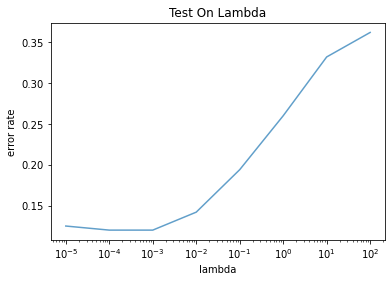

In [4]:
import matplotlib.pyplot as plt

lamda = [10**i for i in range(-5,3)]
plt.plot(lamda,np.array(best_r_errors),alpha = 0.7)
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("error rate")
plt.title("Test On Lambda")
plt.show()

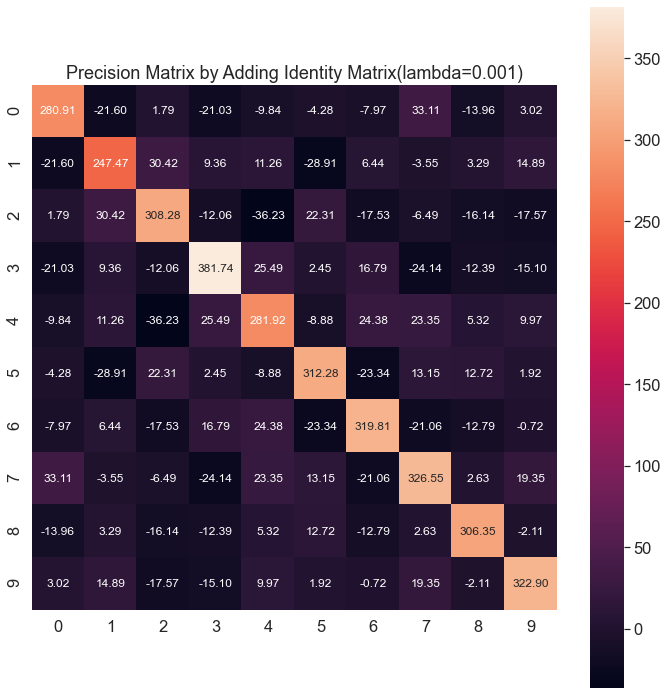

In [33]:
# visualize a precison matrix by using lambda = 0.001
# Only print the first 10 dim for saving computational cost
import seaborn as sns


plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
pre_mat = _cov_inv[0]
hm = sns.heatmap(pre_mat[:10,:10],
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12})
plt.title('Precision Matrix by Adding Identity Matrix(lambda=0.001)')
plt.tight_layout()
plt.show()

#### b) LedoitWolf

In [105]:
from sklearn.covariance import LedoitWolf

errors = []

for j,index in enumerate(indices):
    
    train_index = index[0] 
    test_index = index[1]
    
    mu = []   
    covariance_lw = []
    precision_lw = []
    
    model = LedoitWolf()
    for i in range(14):
        mu.append(np.reshape(np.mean(X[train_index][y[train_index]==i],axis=0),(768,1)))
        cov = model.fit(X[train_index][y[train_index]==i])
        covariance_lw.append(cov.covariance_)
        precision_lw.append(cov.get_precision())
    
    _cov_inv = precision_lw
    _cov_slogdet = np.linalg.slogdet(covariance_lw)[1]
    
    error = 0
    total = 0
    
    for i in range(14):
        label_error = 0
        for vec in X[test_index][y[test_index]==i]:
            test_data_number = len(X[test_index][y[test_index]==i])
            pred = max_pro(vec.reshape(768,1),mu,_cov_inv,_cov_slogdet)
            if pred != i:
                error+=1
                label_error+=1
        #print("For category",i,"error rate:",round(label_error/test_data_number,3),"error:",label_error)
        total += len(X[test_index][y[test_index]==i])     
    
    print("CV:",j,"Error rate:",round(error/total,3),"misclassifed:",error)
    errors.append(round(error/total,3))
    
#print("For CV:",np.argmin(errors),"The error rate:",errors[np.argmin(errors)])
print("For an eight-way CV, the average error rate: ",round(np.average(errors),3))

CV: 0 Error rate: 0.107 misclassifed: 301
CV: 1 Error rate: 0.128 misclassifed: 357
CV: 2 Error rate: 0.134 misclassifed: 374
CV: 3 Error rate: 0.142 misclassifed: 397
CV: 4 Error rate: 0.124 misclassifed: 347
CV: 5 Error rate: 0.133 misclassifed: 371
CV: 6 Error rate: 0.122 misclassifed: 341
CV: 7 Error rate: 0.133 misclassifed: 373
For a eight-way CV, the average error rate:  0.128


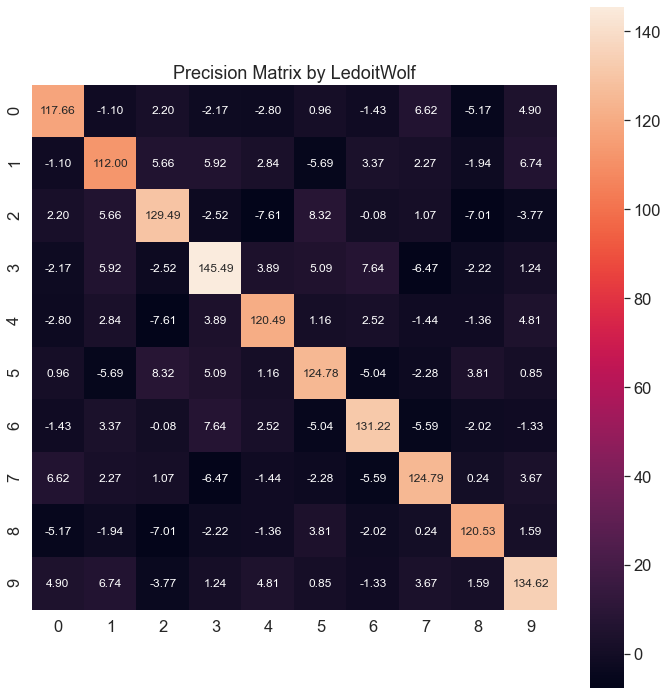

In [41]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
pre_mat = precision_lw[0]
hm = sns.heatmap(pre_mat[:10,:10],
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12})
plt.title('Precision Matrix by LedoitWolf')
plt.tight_layout()
plt.show()

#### c) Graphical LASSO

The Graphical Lasso is a regularization framework for estimating the covariance matrix $\Sigma$, under the assumption that its inverse $\Theta = \Sigma^{-1}$ is sparse. $\Theta$ is called the precision matrix. The graphical lasso problem minimizes a $l_1$-regularized negative log-likelihood:

$
\Theta = \mathop{argmin}\limits_{\Theta \succ0} (tr(S\Theta)-logdet(\Theta) + \lambda||\Theta||_1)
$

Here $S$ is the sample covariance matrix, $||\Theta||_1$ denotes the sum of the absolute values of $\Theta$, and $\lambda$ is a tuning parameter controlling the amount of $l_1$ shrinkage.

In [40]:
from sklearn.covariance import GraphicalLasso

errors_la = []
cov_la = []

#lamda = [10**i for i in range(-4,0)]
lamda = [0.00075,10**(-3),10**(-2),0.1,1]
for j,index in enumerate([indices[0]]):
    
    #print("-----CV:",j,"-----")
    
    train_index = index[0] 
    test_index = index[1]
    
    best_r_errors = []
    
    for r in lamda:
    
        mu = []   
        covariance_gl = []
        precision_gl = []
        
        model = GraphicalLasso(alpha = r,max_iter = 3000,tol= 0.1)
        
        for i in range(14):
            mu.append(np.reshape(np.mean(X[train_index][y[train_index]==i],axis=0),(768,1)))
            cov = model.fit(X[train_index][y[train_index]==i])
            #print(r,i,"Complete")
            covariance_gl.append(cov.covariance_)
            precision_gl.append(cov.precision_)
        
        cov_la.append(covariance_gl)
        
        _cov_inv = precision_gl
        _cov_slogdet = np.linalg.slogdet(covariance_gl)[1]
        
        error = 0
        total = 0
        
        for i in range(14):
            label_error = 0
            for vec in X[test_index][y[test_index]==i]:
                test_data_number = len(X[test_index][y[test_index]==i])
                pred = max_pro(vec.reshape(768,1),mu,_cov_inv,_cov_slogdet)
                if pred != i:
                    error+=1
                    label_error+=1
            #print("For category",i,"error rate:",round(label_error/test_data_number,3),"error:",label_error)
            total += len(X[test_index][y[test_index]==i])
            
        print("Lambda:",r,"Error Rate:",round(error/total,3),"misclassifed:",error)
        best_r_errors.append(round(error/total,3))
        
    print("Best Error Rate:",np.min(best_r_errors),"Lambda:",lamda[np.argmin(best_r_errors)])
    errors_la.append(np.min(best_r_errors))

#print("For an eight-way CV, the average error rate: ",round(np.average(errors),3))

0.00075 0 Complete
0.00075 1 Complete


D:\Anaconda3\envs\ECE601\lib\site-packages\sklearn\covariance\_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002514442866528986, tolerance: 0.00013439387840572423
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


0.00075 2 Complete


D:\Anaconda3\envs\ECE601\lib\site-packages\sklearn\covariance\_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032824579340963445, tolerance: 0.00011547244672018951
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


0.00075 3 Complete
0.00075 4 Complete


D:\Anaconda3\envs\ECE601\lib\site-packages\sklearn\covariance\_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012988847408623716, tolerance: 3.63011440213087e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


0.00075 5 Complete
0.00075 6 Complete
0.00075 7 Complete
0.00075 8 Complete
0.00075 9 Complete
0.00075 10 Complete
0.00075 11 Complete


D:\Anaconda3\envs\ECE601\lib\site-packages\sklearn\covariance\_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002412067742630919, tolerance: 0.00010318482995447767
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


0.00075 12 Complete
0.00075 13 Complete
Lambda: 0.00075 Error Rate: 0.154 misclassifed: 430
0.001 0 Complete
0.001 1 Complete
0.001 2 Complete


D:\Anaconda3\envs\ECE601\lib\site-packages\sklearn\covariance\_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036656141608183354, tolerance: 0.00011547244672018951
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


0.001 3 Complete
0.001 4 Complete
0.001 5 Complete
0.001 6 Complete
0.001 7 Complete
0.001 8 Complete
0.001 9 Complete
0.001 10 Complete
0.001 11 Complete
0.001 12 Complete
0.001 13 Complete
Lambda: 0.001 Error Rate: 0.158 misclassifed: 442
0.01 0 Complete
0.01 1 Complete
0.01 2 Complete
0.01 3 Complete
0.01 4 Complete
0.01 5 Complete
0.01 6 Complete
0.01 7 Complete
0.01 8 Complete
0.01 9 Complete
0.01 10 Complete
0.01 11 Complete
0.01 12 Complete
0.01 13 Complete
Lambda: 0.01 Error Rate: 0.212 misclassifed: 595
0.1 0 Complete
0.1 1 Complete
0.1 2 Complete
0.1 3 Complete
0.1 4 Complete
0.1 5 Complete
0.1 6 Complete
0.1 7 Complete
0.1 8 Complete
0.1 9 Complete
0.1 10 Complete
0.1 11 Complete
0.1 12 Complete
0.1 13 Complete
Lambda: 0.1 Error Rate: 0.307 misclassifed: 860
1 0 Complete
1 1 Complete
1 2 Complete
1 3 Complete
1 4 Complete
1 5 Complete
1 6 Complete
1 7 Complete
1 8 Complete
1 9 Complete
1 10 Complete
1 11 Complete
1 12 Complete
1 13 Complete
Lambda: 1 Error Rate: 0.307 miscla

In [43]:
best_r_errors

[0.154, 0.158, 0.212, 0.307, 0.307]

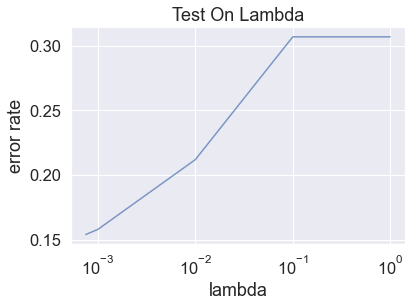

In [14]:
import matplotlib.pyplot as plt
best_r_errors = [0.154, 0.158, 0.212, 0.307, 0.307]
lamda = [0.00075,10**(-3),10**(-2),0.1,1]
plt.plot(lamda,np.array(best_r_errors),alpha = 0.7)
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("error rate")
plt.title("Test On Lambda")
plt.show()

In [42]:
from sklearn.covariance import GraphicalLasso
for j,index in enumerate([indices[0]]):
    
    train_index = index[0] 
    test_index = index[1]
  
    model = GraphicalLasso(alpha = 0.00075,max_iter = 3000,tol= 0.1)
    
    cov = model.fit(X[train_index][y[train_index]==0])
    pre_gl = cov.precision_

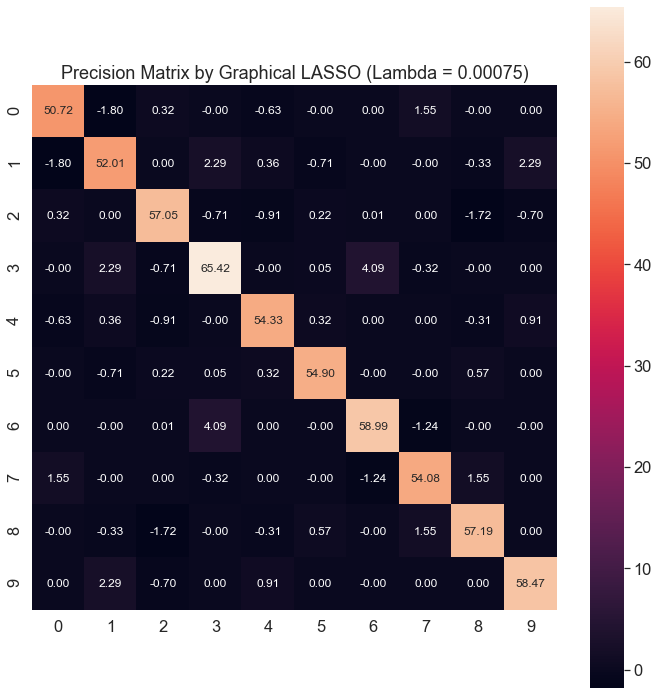

In [45]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
pre_mat = precision_gl[0]
hm = sns.heatmap(pre_mat[:10,:10],
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12})
plt.title('Precision Matrix by Graphical LASSO (Lambda = 0.00075)')
plt.tight_layout()
plt.show()